In [1]:
import seaborn as sns
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
from pliar import common as cmn

In [2]:
folds = pl.read_csv("../data/paper_models/fold_info.csv")

In [3]:
ranking_df = []
for file in Path("../data/processed/alignment/").glob("*attribution_ranking.csv"):
    model, split_type, split = (
        file.stem.split("_")[0],
        file.stem.split("_")[1],
        file.stem.split("_")[2],
    )
    ranking_df.append(
        pl.read_csv(file).with_columns(
            pl.lit(model).alias("model"),
            pl.lit(split_type).alias("split_type"),
            pl.lit(split).alias("dataset"),
        )
    )

ranking_df = pl.concat(ranking_df)

In [4]:
ranking_df.columns

['activity_id',
 'predicted_value',
 'masked_residue_index',
 'predicted_value_masked',
 'masked_residue_type',
 'delta',
 'H-Bond (P-Don)',
 'H-Bond (P-Acc)',
 'Hydroph. Intr.',
 'Pi Stack.',
 'Salt Bridge',
 'Pi-Cation',
 'residue_importance',
 'dunbrack_simplified',
 'UniprotID',
 'n',
 'r2',
 'interaction_type',
 'attr_rank',
 'is_relevant',
 'num_relevant',
 'num_residues',
 'isolated_attr_rank',
 'model',
 'split_type',
 'dataset']

In [5]:
num_non_key = (pl.col.num_residues - pl.col.num_relevant).clip(1)
auroc = (num_non_key - pl.col.isolated_attr_rank - 1).clip(0) / num_non_key

In [6]:
model_names = {
    "cgnn": "CGNN",
    "cgnn3d": "CGNN-3D",
    "dimenet": "DimeNet++",
}
split_names = {"pocket": "Pocket Split", "scaffold": "Scaffold Split"}
dataset_names = {"train": "Train", "test": "Test"}


def with_paper_names(df):
    return df.with_columns(
        pl.col.model.map_elements(model_names.get, return_dtype=str),
        pl.col.split_type.map_elements(split_names.get, return_dtype=str),
        pl.col.dataset.map_elements(dataset_names.get, return_dtype=str),
    )


### Overal R-AUROC
Transform attribution ranks to R-AUROC score within each data point (kinase ligand complex)

In [7]:
ranking_df["interaction_type"].unique()

interaction_type
str
"""Pi-Cation"""
"""Pi-Stack"""
"""Hydrophobic"""
"""Salt Bridge"""
"""H-Bond (PA)"""
"""H-Bond (PD)"""


In [8]:
rank_auroc_data = ranking_df.group_by(
    "model",
    "split_type",
    "dataset",
    "activity_id",
).agg(auroc.mean().alias("rank_auroc"))

2025-11-04 11:43:22,237 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_rank_auroc.svg ...
2025-11-04 11:43:22,271 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_rank_auroc.pdf ...
2025-11-04 11:43:22,359 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_rank_auroc.png ...


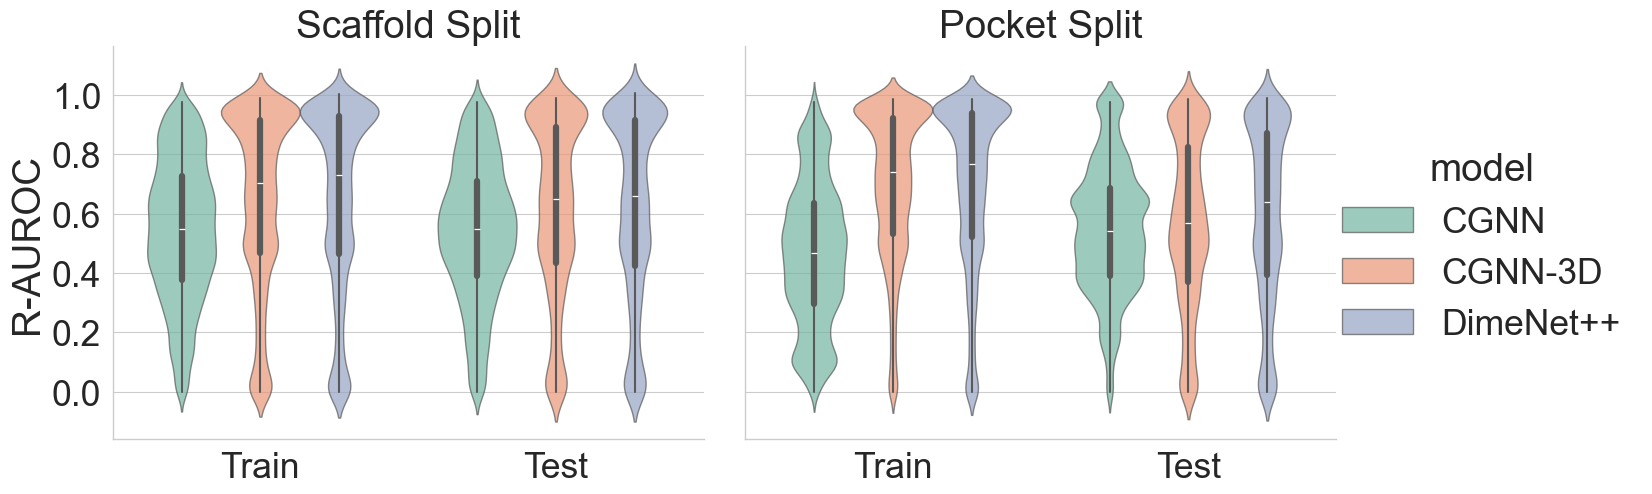

In [9]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.9)
grid = sns.catplot(
    with_paper_names(rank_auroc_data.sort("dataset", descending=True)),
    hue="model",
    hue_order=["CGNN", "CGNN-3D", "DimeNet++"],
    y="rank_auroc",
    x="dataset",
    col="split_type",
    col_order=["Scaffold Split", "Pocket Split"],
    kind="violin",
    palette="Set2",
    alpha=0.7,
    aspect=1.2,
    height=6,
)

grid.axes[0][0].set_ylabel("R-AUROC")
for ax in grid.axes[0]:
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_xlabel("")

# grid.figure.suptitle("Rank AUROC PLI-alignment ($\\uparrow$)", y=1.1)
cmn.write_figure("pli_rank_auroc")

In [10]:
pl.Config.set_tbl_rows(12)
print(
    rank_auroc_data.group_by("split_type", "dataset", "model")
    .agg(pl.col("rank_auroc").median().round(3))
    .sort("model", "split_type", "dataset")
)

shape: (12, 4)
┌────────────┬─────────┬─────────┬────────────┐
│ split_type ┆ dataset ┆ model   ┆ rank_auroc │
│ ---        ┆ ---     ┆ ---     ┆ ---        │
│ str        ┆ str     ┆ str     ┆ f64        │
╞════════════╪═════════╪═════════╪════════════╡
│ pocket     ┆ test    ┆ cgnn    ┆ 0.542      │
│ pocket     ┆ train   ┆ cgnn    ┆ 0.466      │
│ scaffold   ┆ test    ┆ cgnn    ┆ 0.549      │
│ scaffold   ┆ train   ┆ cgnn    ┆ 0.549      │
│ pocket     ┆ test    ┆ cgnn3d  ┆ 0.569      │
│ pocket     ┆ train   ┆ cgnn3d  ┆ 0.741      │
│ scaffold   ┆ test    ┆ cgnn3d  ┆ 0.65       │
│ scaffold   ┆ train   ┆ cgnn3d  ┆ 0.703      │
│ pocket     ┆ test    ┆ dimenet ┆ 0.639      │
│ pocket     ┆ train   ┆ dimenet ┆ 0.769      │
│ scaffold   ┆ test    ┆ dimenet ┆ 0.66       │
│ scaffold   ┆ train   ┆ dimenet ┆ 0.732      │
└────────────┴─────────┴─────────┴────────────┘


### AUROC by interaction type

2025-11-04 11:43:23,336 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_rank_auroc_by_interaction_and_model_train.svg ...
2025-11-04 11:43:23,422 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_rank_auroc_by_interaction_and_model_train.pdf ...
2025-11-04 11:43:23,512 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_rank_auroc_by_interaction_and_model_train.png ...


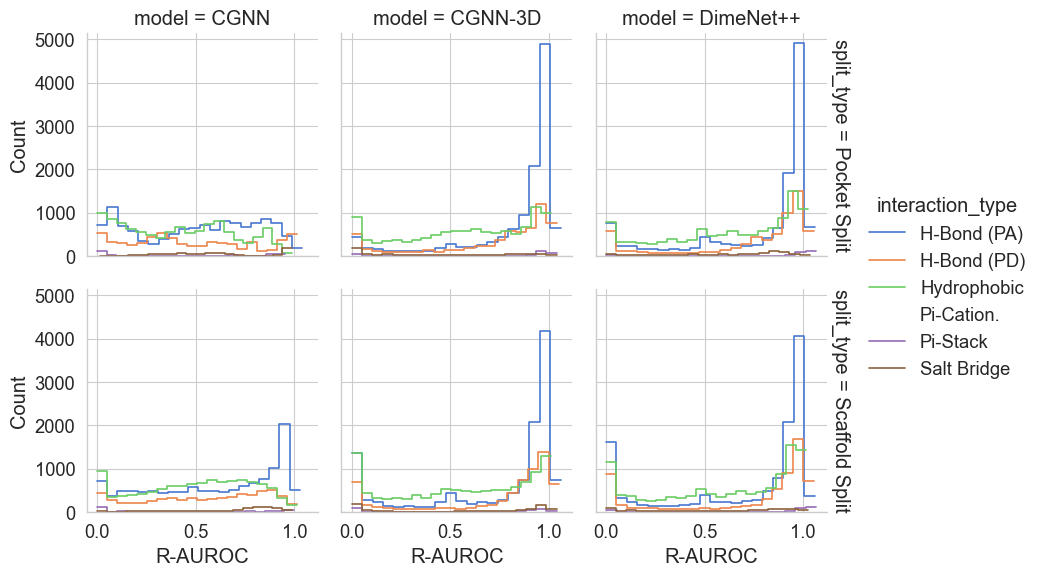

In [11]:
# micro averaging
interaction_rank_auroc = rank_auroc_data = ranking_df.group_by(
    "model", "split_type", "dataset", "activity_id", "interaction_type"
).agg(auroc.mean().alias("rank_auroc"))


ITR_TYPES = [
    "H-Bond (PA)",
    "H-Bond (PD)",
    # "Halogen Bonds",
    "Hydrophobic",
    "Pi-Cation.",
    "Pi-Stack",
    "Salt Bridge",
]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
grid = sns.FacetGrid(
    with_paper_names(interaction_rank_auroc.filter(pl.col.dataset == "train")),
    row="split_type",
    col="model",
    col_order=["CGNN", "CGNN-3D", "DimeNet++"],
    hue="interaction_type",
    hue_order=ITR_TYPES,
    palette="muted",
    margin_titles=True,
)
grid.map_dataframe(
    sns.histplot,
    x="rank_auroc",
    fill=False,
    element="step",
    bins=20,
)
grid.add_legend()

cmn.write_figure("pli_rank_auroc_by_interaction_and_model_train")
for ax in grid.axes[1]:
    ax.set_xlabel("R-AUROC")

2025-11-04 11:43:23,842 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_summary_auroc_by_interaction.svg ...
2025-11-04 11:43:23,940 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_summary_auroc_by_interaction.pdf ...
2025-11-04 11:43:24,007 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_summary_auroc_by_interaction.png ...


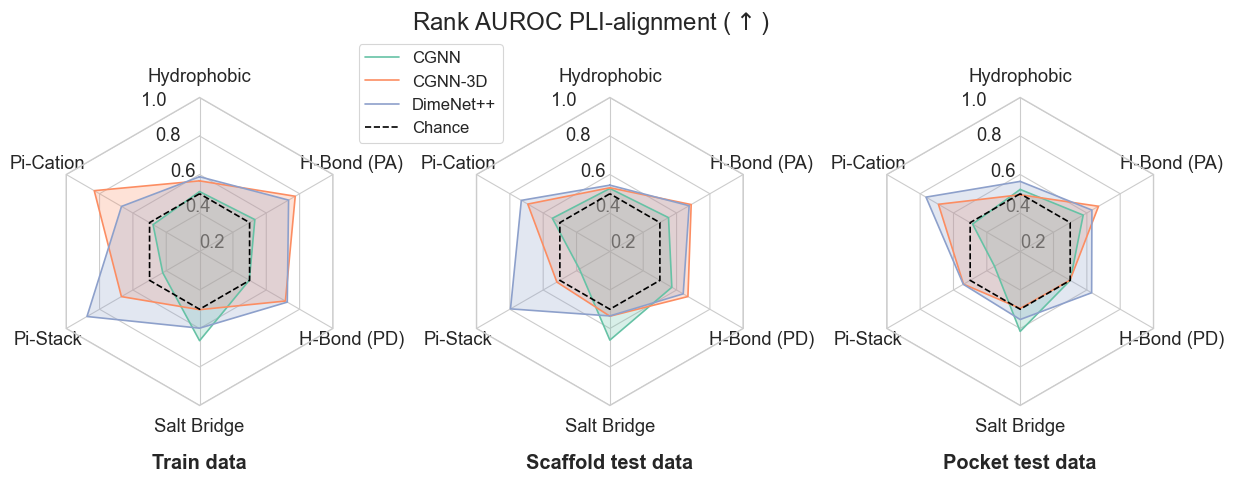

In [12]:
sns.set_context("paper", font_scale=1.5)
# macro averaging
interaction_rank_auroc = ranking_df.group_by(
    "model", "split_type", "dataset", "interaction_type"
).agg(auroc.mean().alias("rank_auroc"))


theta1 = cmn.radar_factory(6, frame="polygon")
theta2 = cmn.radar_factory(6, frame="polygon")
theta3 = cmn.radar_factory(6, frame="polygon")
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, subplot_kw=dict(projection="radar"), figsize=(15, 4)
)
cmn.radar_plot(
    with_paper_names(interaction_rank_auroc.filter(pl.col.dataset == "train")),
    factor="interaction_type",
    factor_order=[
        "Hydrophobic",
        "Pi-Cation",
        "Pi-Stack",
        "Salt Bridge",
        "H-Bond (PD)",
        "H-Bond (PA)",
    ],
    y="rank_auroc",
    hue="model",
    hue_order=["CGNN", "CGNN-3D", "DimeNet++"],
    palette="Set2",
    estimator="mean",
    theta=theta1,
    ax=ax1,
)

cmn.radar_plot(
    with_paper_names(
        interaction_rank_auroc.filter(pl.col.dataset == "test").filter(
            pl.col.split_type == "scaffold"
        )
    ),
    factor="interaction_type",
    factor_order=[
        "Hydrophobic",
        "Pi-Cation",
        "Pi-Stack",
        "Salt Bridge",
        "H-Bond (PD)",
        "H-Bond (PA)",
    ],
    y="rank_auroc",
    hue="model",
    hue_order=["CGNN", "CGNN-3D", "DimeNet++"],
    palette="Set2",
    estimator="mean",
    theta=theta2,
    ax=ax2,
)

cmn.radar_plot(
    with_paper_names(
        interaction_rank_auroc.filter(pl.col.dataset == "test").filter(
            pl.col.split_type == "pocket"
        )
    ),
    factor="interaction_type",
    factor_order=[
        "Hydrophobic",
        "Pi-Cation",
        "Pi-Stack",
        "Salt Bridge",
        "H-Bond (PD)",
        "H-Bond (PA)",
    ],
    y="rank_auroc",
    hue="model",
    hue_order=["CGNN", "CGNN-3D", "DimeNet++"],
    palette="Set2",
    estimator="mean",
    theta=theta3,
    ax=ax3,
)

ax1.set_title("Train data", y=-0.23, weight="bold")
ax2.set_title("Scaffold test data", y=-0.23, weight="bold")
ax3.set_title("Pocket test data", y=-0.23, weight="bold")
for ax in (ax1, ax2, ax3):
    ax.set_ylim(0.2, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.plot(ax1.get_xticks(), [0.5] * 6, color="black", linestyle="--", label="Chance")
ax2.plot(ax2.get_xticks(), [0.5] * 6, color="black", linestyle="--")
ax3.plot(ax3.get_xticks(), [0.5] * 6, color="black", linestyle="--")

ax1.legend(fontsize="xx-small")
sns.move_legend(ax1, "upper center", bbox_to_anchor=(1.25, 1.2), fontsize="small")
fig.suptitle("Rank AUROC PLI-alignment ($\\uparrow$)", y=1.1)
cmn.write_figure("pli_summary_auroc_by_interaction", dpi=300)


### Load test predictions and analyze correlation between predicitive error and R-AUROC

In [13]:
test_predictions = pl.read_csv("../data/processed/test_predictions.csv")
test_predictions.columns

['activity_id',
 'predicted_value',
 'model',
 'split_type',
 'dataset',
 'split_fold',
 'activities.standard_value',
 'dunbrack_simplified',
 'abreviated_dunbrack_state',
 'UniprotID',
 'similar.klifs_structure_id',
 'compound_structures.canonical_smiles',
 'dfg_state',
 'dunbrack_conf',
 'dunbrack_active',
 'docking.predicted_rmsd',
 'absolute_error',
 'squared_error']

In [14]:
error_and_auroc = rank_auroc_data.join(
    test_predictions.select(
        pl.col.activity_id,
        pl.col.model,
        pl.col.split_type,
        pl.col.dataset,
        pl.col.absolute_error,
        pl.col.squared_error,
        pl.col.dunbrack_conf,
    ),
    on=["activity_id", "model", "dataset", "split_type"],
)
error_and_auroc.head(3)

model,split_type,dataset,activity_id,interaction_type,rank_auroc,absolute_error,squared_error,dunbrack_conf
str,str,str,i64,str,f64,f64,f64,str
"""dimenet""","""pocket""","""test""",18060595,"""H-Bond (PA)""",0.975904,0.510314,0.26042,"""BLAminus"""
"""dimenet""","""pocket""","""test""",18060595,"""Hydrophobic""",0.0,0.510314,0.26042,"""BLAminus"""
"""dimenet""","""pocket""","""test""",15684506,"""Salt Bridge""",0.227848,1.309007,1.713499,"""BLAminus"""


In [15]:
error_and_auroc.group_by("dataset", "split_type", "model").agg(
    pl.corr(
        pl.col.absolute_error,
        pl.col.rank_auroc,
        method="spearman",
    ).alias("corr")
)

dataset,split_type,model,corr
str,str,str,f64
"""test""","""scaffold""","""cgnn""",-0.031689
"""test""","""pocket""","""cgnn3d""",-0.020023
"""test""","""scaffold""","""dimenet""",-0.006439
"""test""","""scaffold""","""cgnn3d""",-0.016039
"""test""","""pocket""","""cgnn""",-0.020789
"""test""","""pocket""","""dimenet""",0.00874


2025-11-04 11:43:24,668 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_and_error.svg ...
2025-11-04 11:43:24,891 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_and_error.pdf ...
2025-11-04 11:43:25,149 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_and_error.png ...


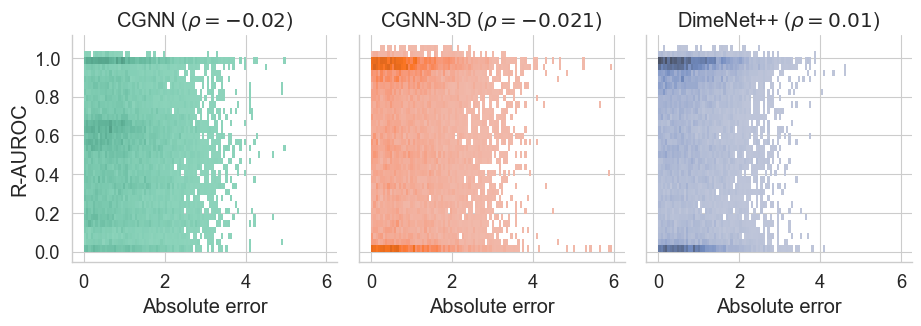

In [16]:
g = sns.displot(
    data=with_paper_names(error_and_auroc.filter(pl.col.split_type == "pocket")),
    x="absolute_error",
    y="rank_auroc",
    col="model",  # use pretty names for facet titles
    col_order=["CGNN", "CGNN-3D", "DimeNet++"],  # consistent order
    hue="model",  # use pretty names for facet titles
    hue_order=["CGNN", "CGNN-3D", "DimeNet++"],  # consistent order
    kind="hist",
    facet_kws=dict(sharex=True, sharey=True),
    palette="Set2",
    height=3.5,
    aspect=0.9,
    legend=False,
)

# Axis labels
g.set_axis_labels("Absolute error", "R-AUROC")

g.axes[0][0].set_title("CGNN ($\\rho = -0.02$)")
g.axes[0][1].set_title("CGNN-3D ($\\rho = -0.021$)")
g.axes[0][2].set_title("DimeNet++ ($\\rho = 0.01$)")

# Final layout tweaks
plt.tight_layout()
cmn.write_figure("pli_and_error")
